# BIOS 512 Final Project
### North Carolina Air Quality Measurements
#### Christopher Kong

## <ins> Introduction </ins>
Air pollution has referred to the release of pollutants in the air which are classified based on whether they are detrimental to humans and/or the planet. Therefore, air pollution has become a recent concern among various countries and leaders. For example, the United States have established the Environmental Protection Agency (EPA) which has become responsible for collecting air pollution data concerning ozone and particulate matter. This narrative will investigate the <b> EPA air pollution data focused on North Carolina counties </b> to determine any noticeable trends.

## <ins>Initial Configuration</ins>
First thing first is to install the libraries and packages needed to analyze and work-up the data to something that can be analyzed. RSocrata was used to retrieve the data, and all other dependencies were utilized to sort and construct the data. 

In [1]:
install.packages("RSocrata")
library("RSocrata")
library("tidyverse")
library("dplyr")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.3     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



After installing those, the air pollution data is read from the Center for Disease Control (CDC) which was provided by the EPA. Because we are looking at air pollution data specifically from North Carolina, we filter all other states out. We are also looking at the number of days with maximum 8-hour average ozone concentration over the National Ambient Air Quality Standard for each of the North Carolina counties. From there, the data is then filtered further to make it easier to work with as well as converting the string values to numeric ones for easier usage in analysis. Finally, we observe only select counties as the data would be hard to analyze. The counties were selected depending on if they reported data for all 15 years between 1999 to 2013 as well as if their average of reported number of days was above or equal to 14 days. The counties that were used in this analysis are the following: Davie, Forsyth, Haywood, Mecklenburg, Rowan, and Wake.

In [2]:
raw_smoke_df <- read.socrata("https://data.cdc.gov/resource/cjae-szjv.json")

raw_smoke_df = raw_smoke_df %>% 
                filter(statename == "North Carolina",
                   measurename == "Number of days with maximum 8-hour average ozone concentration over the National Ambient Air Quality Standard") %>%
                select(statename, countyname, reportyear, value) %>%
                mutate(value = as.numeric(as.character(value))) %>%
                group_by(countyname) %>%
                mutate(average = mean(value), total = n()) %>%
                filter(total == 15, average >= 14) %>%
                ungroup()

## <ins>Air Quality Across All North Carolina Counties Per Year</ins>
Firstly, we observe the air quality in North Carolina as whole. This is important as we want to know if the relative air pollution for the state has gone down since 1999 to 2013. In order to do so, we take our raw data and arrange it so that the relative sum of days per year is calculated and data is grouped by each reported year.

In [3]:
county_df = raw_smoke_df %>% 
            group_by(reportyear) %>%
            summarize(totalyear = sum(value))

Once doing that, we create a bar graph to observe the air quality per year in North Carolina. To do so, we create a bar graph using the reported years on the x-axis and the summation of days calculated in the previous state on the y-axis. Then some aesthetic changes are made such as scaling and titles for the axes.

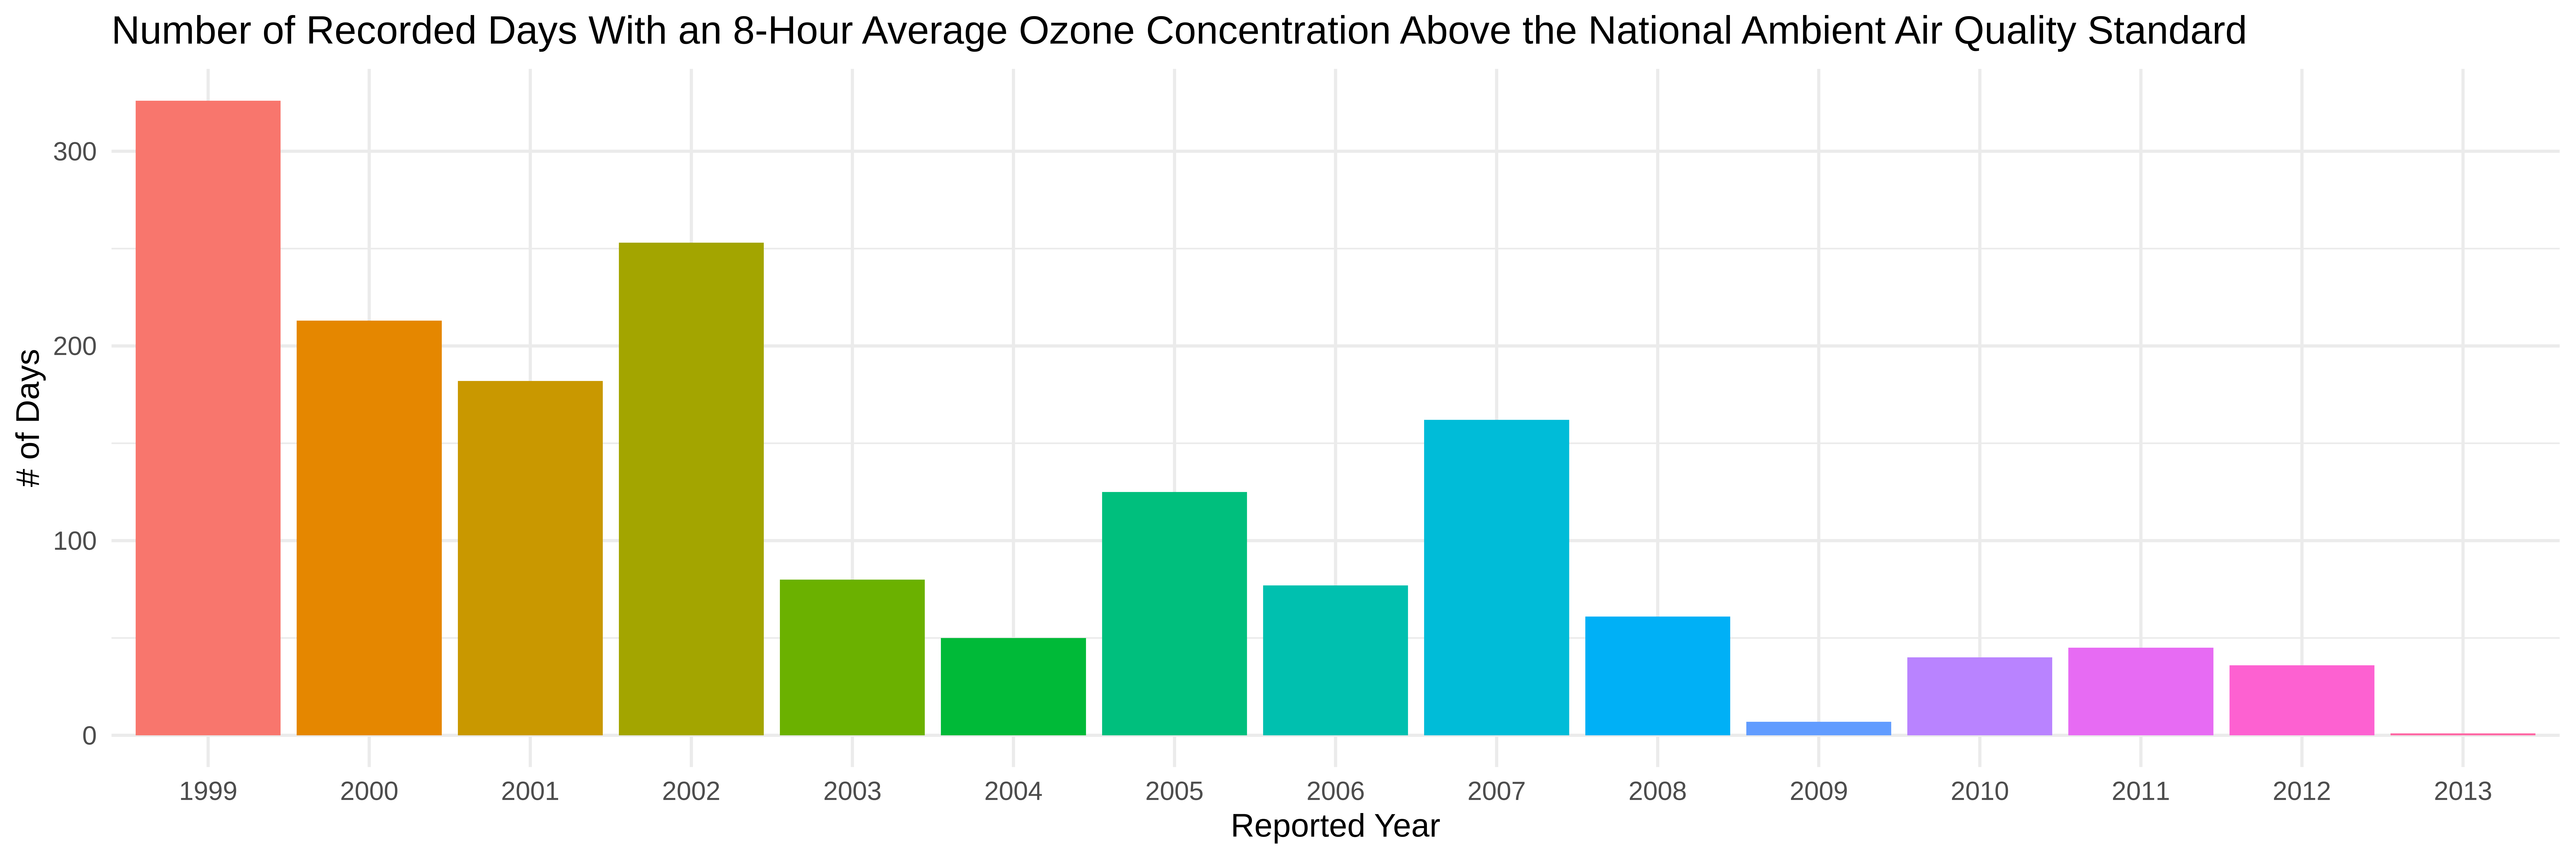

In [14]:
options(repr.plot.width = 12, repr.plot.height = 4, repr.plot.res = 1000)
p = ggplot(county_df, aes(x = reportyear, y=totalyear, fill=reportyear))
p = p + geom_col()
p = p + theme_minimal()
p = p + theme(legend.position = "none")
p = p + scale_color_brewer()
p = p + labs(x="Reported Year", y="# of Days", title="Number of Recorded Days With an 8-Hour Average Ozone Concentration Above the National Ambient Air Quality Standard")
p

From the bar graph above there are several observations to make. For one, it does appear that the relative amount of air pollution has decreased over the years. The reason is that the year 1999 reported a maximum number of days with 326 days. After this year, no other reported year reports several days that large. It is noteworthy to mark the years <b> 2002, 2005, and 2007 </b>. These years reported a significant increase in the number of reported days. To determine where this large increase may come from, it may be useful to observe the individual counties.

## <ins> Air Pollution Per County </ins>
To determine which counties contributed the most to air pollution over this time, it would make sense to build a timeline of the various counties and their reported number of days per year. Firstly, it is important to take the filtered data and group it by the names of the counties.

In [5]:
change_df = raw_smoke_df %>%
            group_by(countyname)

To plot the timelines for each of the counties, it is necessary to configure the data. Firstly, it is important to set up the respective ggplot graphics. Additionally, the aesthetics are coded for each. 

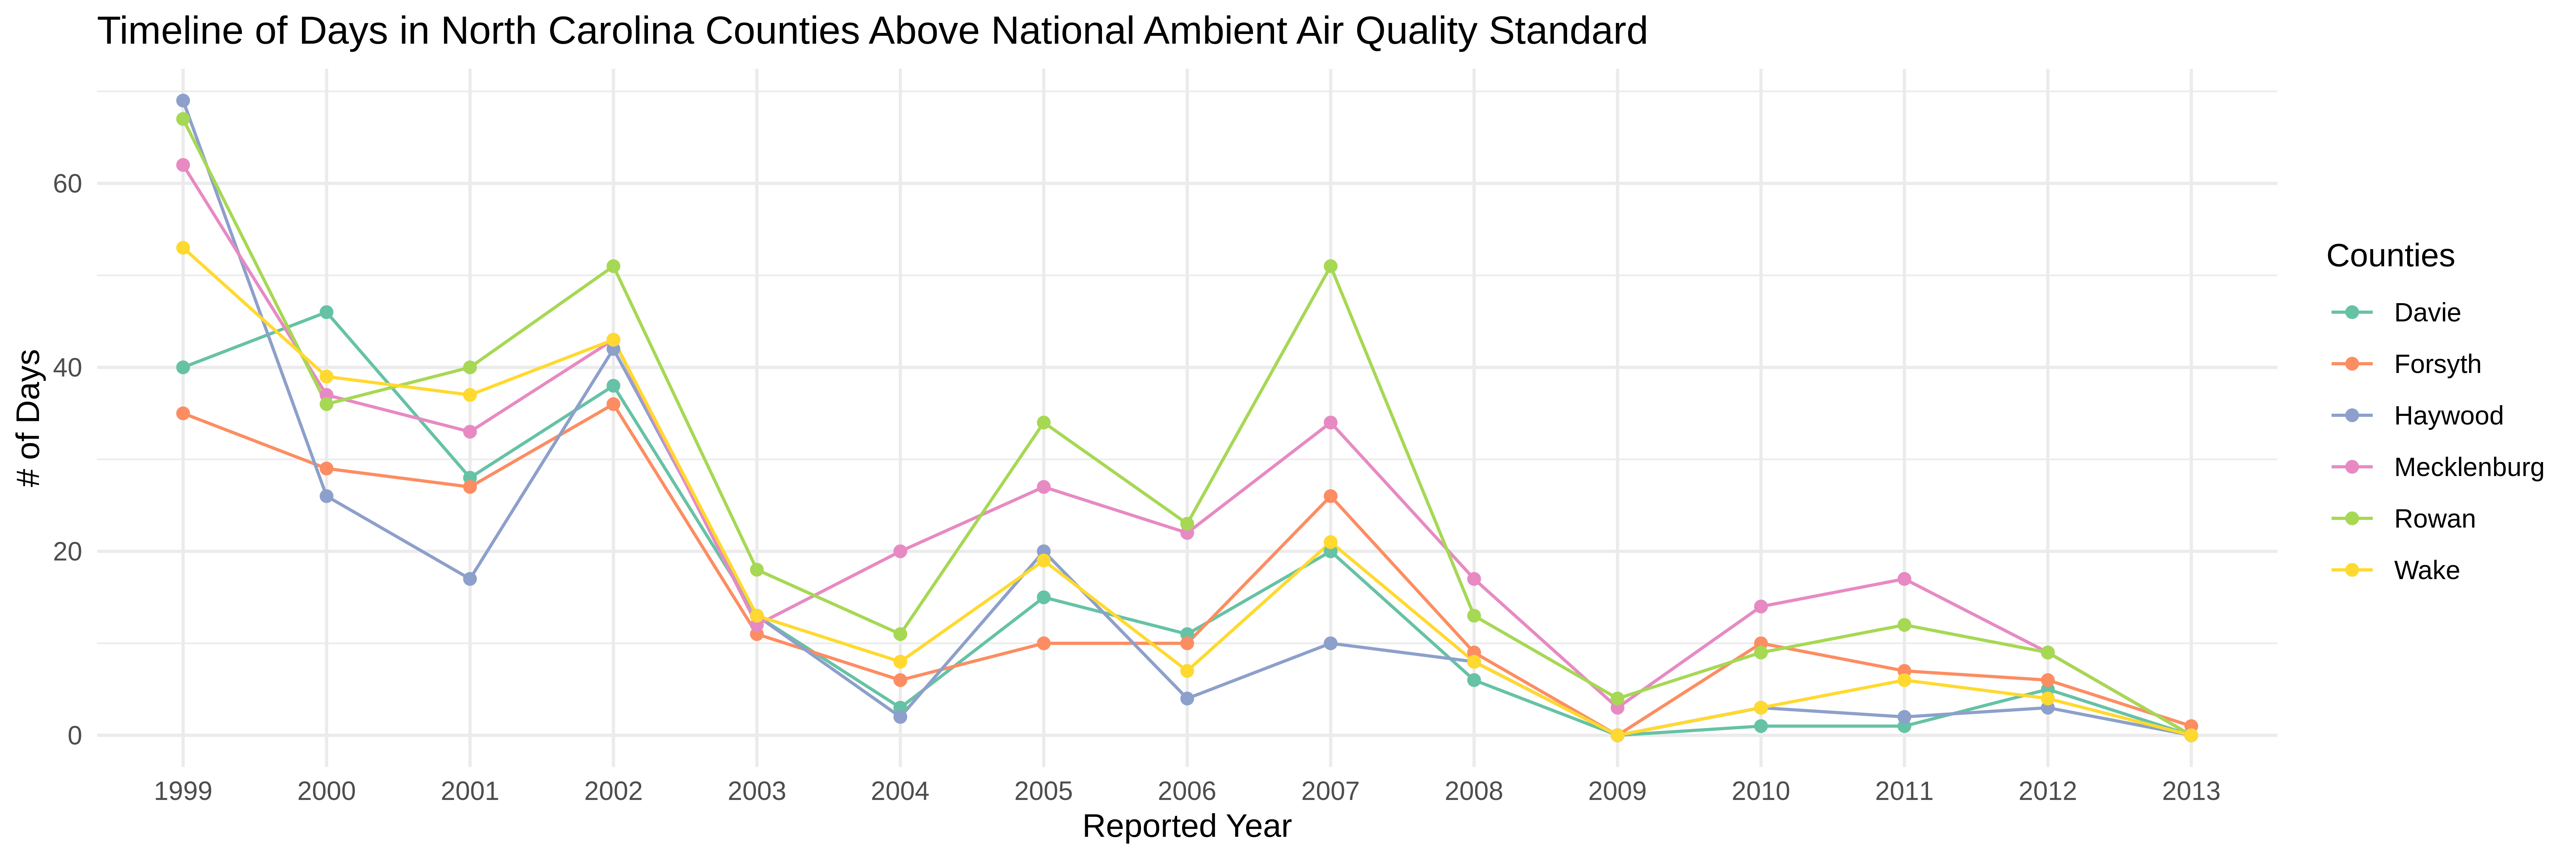

In [13]:
options(repr.plot.width = 12, repr.plot.height = 4, repr.plot.res = 600)

g = ggplot(change_df, aes(x=reportyear, y=value, group = countyname, color=countyname))
g = g + geom_line() + geom_point()
g = g + theme_minimal()
g = g + scale_color_brewer(palette="Set2")
g = g + labs(x="Reported Year", y="# of Days", col = guide_legend("Counties"), title="Timeline of Days in North Carolina Counties Above National Ambient Air Quality Standard")
g

From the graph, there are multiple observations that can be made. For one, it appears that Rowan and Mecklenburg counties are the major sources of air pollution. The reason is because these two are found to report the largest number of days for most of the years. The only exceptions are 1999 to 2001 as Wake and Davie counties reported higher number of days at these points. In terms of the large increases mentioned in the previous graph for years <b> 2002, 2005, and 2007 </b> Rowan and Mecklenburg reported the largest number of days for these years. This observation means that these large increases are mostly likely to be attributed to these counties. One other notable aspect of the graph is that it follows the reported overall decrease in air pollution as the years go on. This is made evident by looking at 2013 which reported near 0 days to 199 which had values in the 60s. To provide additional evidence for this decrease over the years, it would be helpful to provide an <b> empirical cumulative density function (ECDF) graph </b>.

## <ins> Distribution of Air Pollution </ins>
An ECDF graph is useful as it allows us to make observations regarding the distribtuion of days. This would allow us to support that there is a relative decrease in the amount of pollution as the years go on. First thing is to calcualte the cumulative sums for the reported days. From there, it nessary to calculate the realtive fraction of the reported days per year to the total number of days. 

In [7]:
density_df = raw_smoke_df %>%
                group_by(reportyear) %>%
                summarize(count = sum(value)) %>%
                mutate(density_count = cumsum(count), count=count/1658)%>%
                arrange(density_count) %>%
                ungroup()

To build the ECDF graph for this data, we build it using the stat_ecdf function provided by ggplot. We plot the cumulative sum of days on the x-axis while the relative fraction of days on the y-axis. Additionally, a vertical line indicating the year 2006 was reported as this overlapped where the ECDF graph hit 50% of the total number of days. Finally, aesthetic encodings were provided such as a label for the vertical line to make the graph easier to analyze.

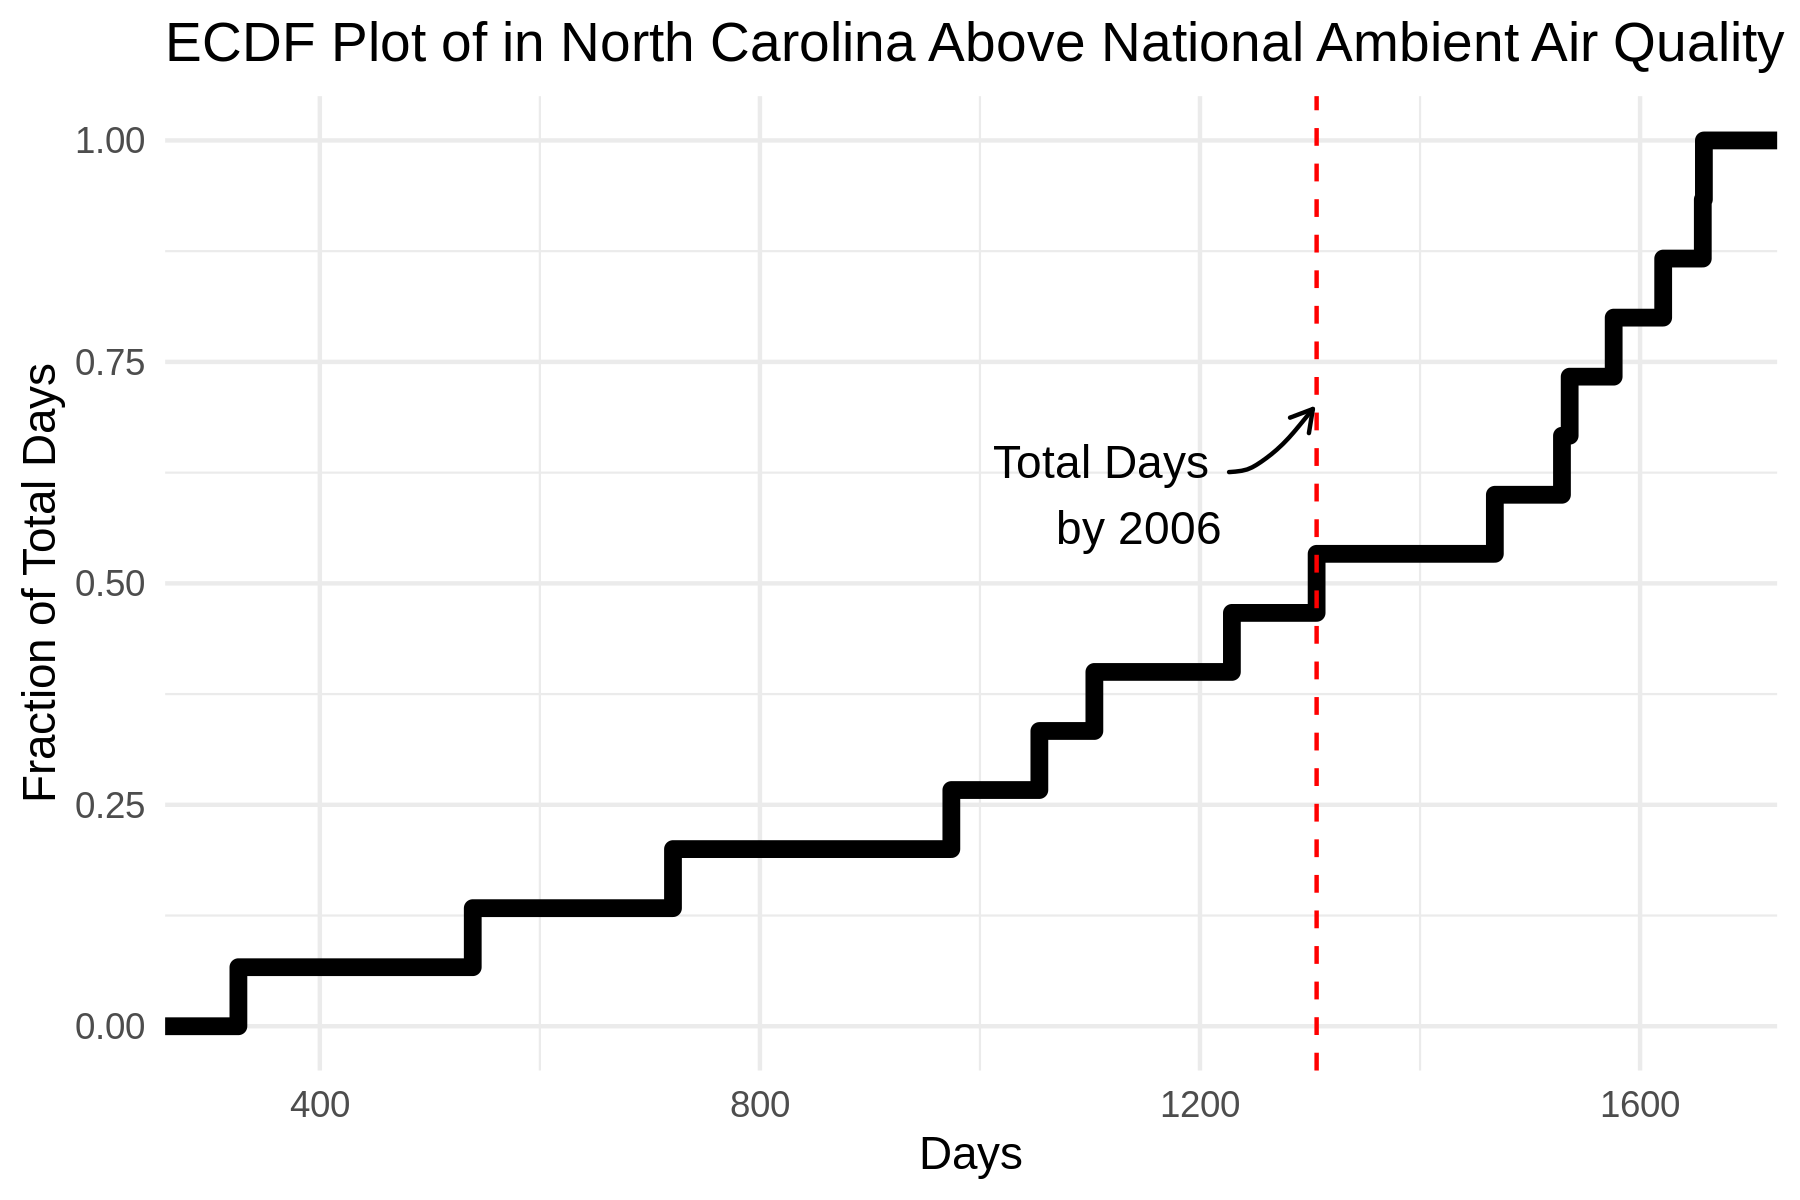

In [12]:
options(repr.plot.width = 6, repr.plot.height = 4, repr.plot.res = 300)

b = ggplot(density_df,aes(x=density_count, y=count))
b = b + stat_ecdf(size = 2)
b = b + theme_minimal()
b = b + labs (x="Days", y="Fraction of Total Days", title="ECDF Plot of in North Carolina Above National Ambient Air Quality Standard")
b = b + geom_vline(xintercept=1306,color="red",linetype="dashed")

b = b + ggrepel::geom_text_repel(
    data = data.frame(density_count = 1306, count= 0.7),
    nudge_x = -100,
    nudge_y = -0.10,
    segment.curvature = 0.1,
    label = "Total Days \n by 2006",
    hjust= "right",
    arrow = arrow(length = unit(0.025, "npc"))
)
b


From the ECDF plot, there are various observations that can be made. For example, the total number of days reported from 1999 to 2013 is approximately 1,600 days that reported air pollution between all the counties. From there it can be seen that at least 50% of the reported days were reported by 2006. This indicates that the earlier years reported a higher number of days compared to later years. This is because between 1999 to 2006 there are about 1,300 days which is more than half of the total 1,600 days. This further substantiates that the amount of air pollution has gone down across all the counties over the years. 

## <ins> Conclusion </ins>

From the data and the graphs, it can be concluded that the amount of air pollution has gone down. Additionally, it appears that Mecklenburg and Rowan counties are responsible for the most amount of air pollution among counties accounted for in this study. It would be interesting to see the air pollution data since 2013 since it is now 2021. It appears awareness and consideration of air pollution may be responsible for the decreased amount of air pollution; however, further investigation is required to make such conclusions.